# Load dataset

In [1]:
import sys
from pathlib import Path

# Add project root directory to Python path
root_path = Path.cwd().parent
sys.path.insert(0, str(root_path))

from core import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST

In [2]:
# Load and preprocess MNIST
print("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Loading MNIST dataset...


In [3]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Reshape for CNN: (N, H, W) -> (N, C, H, W) where C=1 for grayscale
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

print(f"Original data shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")

Original data shapes - X_train: (60000, 1, 28, 28), X_test: (10000, 1, 28, 28)


In [4]:

# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.4, random_state=42, stratify=y_train
)

print(f"Data shapes - Train: {X_tr.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Data shapes - Train: (36000, 1, 28, 28), Val: (24000, 1, 28, 28), Test: (10000, 1, 28, 28)


In [5]:
# Create CNN model
model = CNN()

# Add layers
model.add_layer(Conv2D(in_channels=1, out_channels=8, kernel_size=3, padding=1))
model.add_layer(ReLULayer())
model.add_layer(MaxPool2D(pool_size=2))

model.add_layer(Conv2D(in_channels=8, out_channels=16, kernel_size=3, padding=1))
model.add_layer(ReLULayer())
model.add_layer(MaxPool2D(pool_size=2))

model.add_layer(Flatten())
model.add_layer(Linear(input_size=16*7*7, output_size=64))
model.add_layer(ReLULayer())
model.add_layer(Linear(input_size=64, output_size=10))

# Create loss function and optimizer
loss_fn = SoftmaxCrossEntropyLoss()
optimizer = Adam(learning_rate=0.001)

print("\nModel architecture:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {type(layer).__name__}")


Model architecture:
Layer 0: Conv2D
Layer 1: ReLULayer
Layer 2: MaxPool2D
Layer 3: Conv2D
Layer 4: ReLULayer
Layer 5: MaxPool2D
Layer 6: Flatten
Layer 7: Linear
Layer 8: ReLULayer
Layer 9: Linear


In [6]:
# Training configuration
epochs = 1  # Reduced for faster training
batch_size = 32  # Reduced batch size for memory efficiency
train_losses, train_accs, val_accs = [], [], []

print(f"\nStarting training for {epochs} epochs...")
model.train()

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    batches = 0

    # Training loop
    print(f"Epoch {epoch}/{epochs} - Training...")
    batch_count = 0
    for Xb, yb in batch_iterator(X_tr, y_tr, batch_size=batch_size, shuffle=True):
        # Reset gradients
        model.zero_grad()
        
        # Forward pass
        logits = model.forward(Xb)
        
        # Loss calculation
        loss = loss_fn.forward(logits, yb)
        epoch_loss += loss
        
        # Accuracy calculation
        pred = np.argmax(logits, axis=1)
        correct += np.sum(pred == yb)
        total += yb.size
        
        # Backward pass
        grad = loss_fn.backward()
        model.backward(grad)
        
        # Parameter update
        model.update_params(optimizer)
        
        batches += 1
        batch_count += 1
        
        # Progress indicator
        if batch_count % 100 == 0:
            print(f"  Processed {batch_count} batches...")

    # Calculate epoch metrics
    avg_loss = epoch_loss / max(1, batches)
    train_acc = correct / max(1, total)

    # Validation evaluation
    print(f"Epoch {epoch}/{epochs} - Validation...")
    model.eval()
    val_correct = 0
    val_total = 0
    val_batches = 0
    
    for Xb, yb in batch_iterator(X_val, y_val, batch_size=batch_size, shuffle=False):
        val_logits = model.forward(Xb)
        val_pred = np.argmax(val_logits, axis=1)
        val_correct += np.sum(val_pred == yb)
        val_total += yb.size
        val_batches += 1
    
    val_acc = val_correct / max(1, val_total)
    model.train()

    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Progress reporting
    print(f"Epoch {epoch:02d}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Starting training for 1 epochs...
Epoch 1/1 - Training...
  Processed 100 batches...
  Processed 200 batches...
  Processed 300 batches...
  Processed 400 batches...
  Processed 500 batches...
  Processed 600 batches...
  Processed 700 batches...
  Processed 800 batches...
  Processed 900 batches...
  Processed 1000 batches...
  Processed 1100 batches...
Epoch 1/1 - Validation...
Epoch 01/1 | Loss: 0.2175 | Train Acc: 0.9346 | Val Acc: 0.9604


In [7]:
# Final evaluation
print("\nEvaluating on test set...")
model.eval()
test_correct = 0
test_total = 0

for Xb, yb in batch_iterator(X_test, y_test, batch_size=batch_size, shuffle=False):
    test_logits = model.forward(Xb)
    test_pred = np.argmax(test_logits, axis=1)
    test_correct += np.sum(test_pred == yb)
    test_total += yb.size

test_acc = test_correct / test_total
print(f"Final Test Accuracy: {test_acc:.4f}")


Evaluating on test set...
Final Test Accuracy: 0.9664


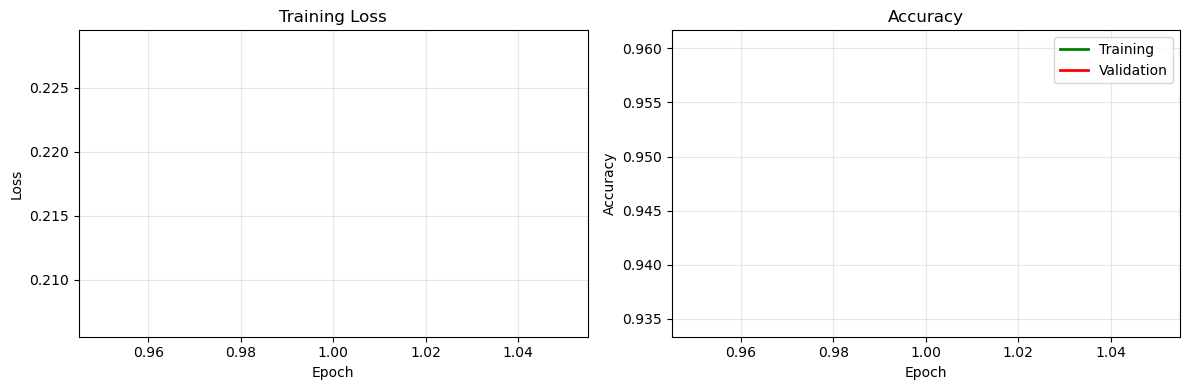

Training completed successfully!


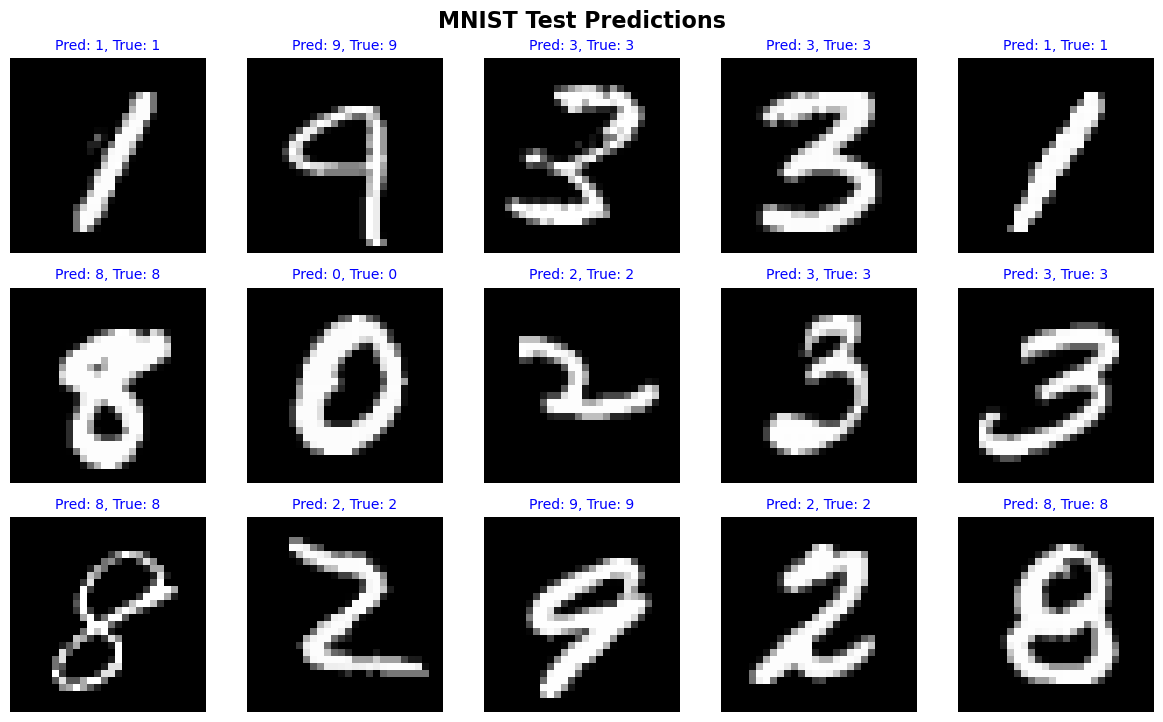

In [8]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-', linewidth=2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, 'g-', label="Training", linewidth=2)
plt.plot(range(1, epochs + 1), val_accs, 'r-', label="Validation", linewidth=2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training completed successfully!")

# Predict and visualize random test images
num_images = 15
indices = np.random.choice(len(X_test), size=num_images, replace=False)

# Set model to evaluation mode
model.eval()

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    # Get image and label
    image_4d = X_test[idx:idx+1]  # Keep 4D shape for model: (1, 1, 28, 28)
    image_2d = X_test[idx, 0]     # 2D shape for display: (28, 28)
    true_label = y_test[idx]

    # Forward pass and prediction
    logits = model.forward(image_4d)
    pred_label = np.argmax(logits)

    # Plot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_2d, cmap='gray')  # Use gray colormap for MNIST
    color = 'blue' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}, True: {true_label}", fontsize=10, color=color)
    plt.axis('off')  # Hide axes for cleaner look

plt.suptitle("MNIST Test Predictions", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Save model
models_dir = root_path / 'models'
models_dir.mkdir(exist_ok=True)
filepath = models_dir / 'mnist_cnn_model.pkl'
save_checkpoint(model, optimizer, filepath)